# Arrow Recognition



In [1]:
import os
import cv2
from glob import glob
import numpy as np
import imutils
from sklearn.metrics import classification_report
import random
from collections import namedtuple

import typing
from typing import Any

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import nn, flatten, Tensor
from torch.optim import Adam
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax
from torch.utils.data import random_split, Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torchsummary import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


## Definitions

### Model Definitions

In [2]:
class LeNet(Module):
	def __init__(self, numChannels, classes, imageShape):
		# call the parent constructor
		super(LeNet, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		# convolutional layer = 20 5x5 filters.
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
		# activation function.
		self.relu1 = ReLU()
		# 2x2 max-pooling to reduce spatial dimensions.
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		# convolutional layer = 20 5x5 filters.
		self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
		# activation function.
		self.relu2 = ReLU()
		# 2x2 max-pooling to reduce spatial dimensions.
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		# fully connected to 500 features.
		self.flatter = torch.nn.Flatten(1)
		self.fc1 = Linear(in_features=50 * (imageShape[0]//4-3) * (imageShape[1]//4-3), out_features=500)
		# activation function. 
		self.relu3 = ReLU()

		# initialize our softmax classifier
		# fully connected to number of classes.
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU => POOL layers
		# x = n x a x b
		# x = 1 x 28 x 28
		x = self.conv1(x) # x = 20 x 24 x 24
		x = self.relu1(x) # x = 20 x 24 x 24
		x = self.maxpool1(x) # x = 20 x 12 x 12

		# pass the output from the previous layer through the second set of CONV => RELU => POOL layers
		x = self.conv2(x) # x = 50 x 8 x 8
		x = self.relu2(x) # x = 50 x 8 x 8
		x = self.maxpool2(x) # x = 50 x 4 x 4

		# flatten the output from the previous layer and pass it through our only set of FC => RELU layers
		x = self.flatter(x) # x = 800
		x = self.fc1(x) # x = 500
		x = self.relu3(x) # x = 500

		# pass the output to our softmax classifier to get our output predictions
		x = self.fc2(x) # x = number of classes = 10
		output = self.logSoftmax(x) # x = 10 

		# return the output predictions
		return output

### Dataset Definitions

In [3]:
Size = namedtuple('ImageSize', ['height', 'width'])
Range = namedtuple('Range', ['min', 'max'])

def drawRandArrow(size: Size, padding: int, lengthRange: Range, thickRange: Range, tipRange: Range, ax: plt.Axes = None, img: np.ndarray = None, grayscale: bool = False, negative: bool = False) -> np.ndarray:
    # Create blank image.
    if img is None:
        img = np.zeros(list(size), np.uint8) if grayscale else np.zeros(list(size) + [3], np.uint8)
        if not negative: img.fill(255)
    else:
        img = img.copy()
    # constant.
    if negative: color = (255,255,255) if len(img.shape) == 3 else 255
    else: color = (0,0,0) if len(img.shape) == 3 else 0 
    # random.
    pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    while True:
        pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
        length = np.sqrt( np.power(pt2[0]-pt1[0], 2) + np.power(pt2[1]-pt1[1], 2) )
        if lengthRange[0] < length < lengthRange[1]: break
    thick = random.randint(*thickRange)
    tipLen = (random.random() * (tipRange[1]-tipRange[0])) + tipRange[0]
    # draw.
    img = cv2.arrowedLine(img, pt1, pt2, color, thick, tipLength=tipLen)
    # show.
    if ax is not None: ax.imshow(img, 'gray')
    return img

def drawRandCircle(size: Size, padding: int, radRange: Range, thickRange: Range, ax: plt.Axes = None, img: np.ndarray = None, grayscale: bool = False, negative: bool = False) -> np.ndarray:
    # create image.
    if img is None:
        img = np.zeros(list(size), np.uint8) if grayscale else np.zeros(list(size) + [3], np.uint8)
        if not negative: img.fill(255)
    else:
        img = img.copy()
    # constant.
    if negative: color = (255,255,255) if len(img.shape) == 3 else 255
    else: color = (0,0,0) if len(img.shape) == 3 else 0 
    # random.
    center = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    radius = random.randint(*radRange)
    thick = random.randint(*thickRange)
    # draw.
    img = cv2.circle(img, center, radius, color, thick)
    # show.
    if ax is not None: ax.imshow(img, 'gray')
    return img

def drawRandRect(size: Size, padding: int, diagRange: Range, thickRange: Range, ax: plt.Axes = None, img: np.ndarray = None, grayscale: bool = False, negative: bool = False) -> np.ndarray:
    # create image.
    if img is None:
        img = np.zeros(list(size), np.uint8) if grayscale else np.zeros(list(size) + [3], np.uint8)
        if not negative: img.fill(255)
    else:
        img = img.copy()
    # constant.
    if negative: color = (255,255,255) if len(img.shape) == 3 else 255
    else: color = (0,0,0) if len(img.shape) == 3 else 0 
    # random.
    pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    while True:
        pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
        diagonal = np.sqrt( np.power(pt2[0]-pt1[0], 2) + np.power(pt2[1]-pt1[1], 2) )
        if diagRange[0] < diagonal < diagRange[1]: break
    thick = random.randint(*thickRange)
    # draw.
    img = cv2.rectangle(img, pt1, pt2, color, thick)
    # show.
    if ax is not None: ax.imshow(img, 'gray')
    return img

def drawRandLine(size: Size, padding: int, lengthRange: Range, thickRange: Range, ax: plt.Axes = None, img: np.ndarray = None, grayscale: bool = False, negative: bool = False) -> np.ndarray:
    # create image.
    if img is None:
        img = np.zeros(list(size), np.uint8) if grayscale else np.zeros(list(size) + [3], np.uint8)
        if not negative: img.fill(255)
    else:
        img = img.copy()
    # constant.
    if negative: color = (255,255,255) if len(img.shape) == 3 else 255
    else: color = (0,0,0) if len(img.shape) == 3 else 0 
    # random.
    pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    while True:
        pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
        length = np.sqrt( np.power(pt2[0]-pt1[0], 2) + np.power(pt2[1]-pt1[1], 2) )
        if lengthRange[0] < length < lengthRange[1]: break
    thick = random.randint(*thickRange)
    # draw.
    img = cv2.line(img, pt1, pt2, color, thick)
    # show.
    if ax is not None: ax.imshow(img, 'gray')
    return img


In [4]:
class ShapeDataset(torch.utils.data.Dataset):
    CLASS_FILENAME = "classes.txt"
    LABEL_FILENAME = "labels.txt"
    
    def __init__(self, root: str, device: torch.device, datasize: int = None, shape_definitions: dict = None, transforms: transforms.Compose = transforms.ToTensor()) -> None:
        super().__init__()
        self._transforms = transforms
        self._root = root
        self._device = device
        self._datasize = datasize
        self._shape_definitions = shape_definitions
        self._classes: typing.List[str] = []
        self._files: typing.List[str] = []
        if all([isinstance(datasize, int), isinstance(shape_definitions, dict)]): 
            self.generate()
        else: 
            self.read_classes()
            self.read_files()
    def __len__(self) -> int: return self._datasize
    def __getitem__(self, index) -> torch.Tensor: return (self.load_data(index), self.load_targets(index))
    
    @property
    def data(self) -> Tensor: return self.load_data()
    @property
    def targets(self) -> Tensor: return self.load_targets()
    @property
    def classes(self) -> typing.List[str]: return self._classes
    @property
    def files(self) -> typing.List[str]: return self._files
    @property
    def transforms(self) -> transforms.Compose: return self._transforms
    @property
    def root(self) -> str: return self._root
    @property
    def device(self) -> torch.device: return self._device
    @property
    def shape_definitions(self) -> dict: return self._shape_definitions
    
    def load_data(self, index: int = None, grayscale: bool = True, do_transform: bool = True) -> Tensor:
        tensors = None
        if index is None:
            tensors = None
            for filepath in self.files:
                image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
                if not isinstance(image, np.ndarray): raise RuntimeError(f"Cannot read image {filepath}")
                if do_transform:
                    image = self.transforms(image).to(self.device).unsqueeze(0)
                    if tensors is None: tensors = image
                    else: tensors = torch.concat([tensors, image])
                else: 
                    image = np.expand_dims(image, 0)
                    if tensors is None: tensors = image
                    else: tensors = np.concatenate([tensors, image])
        else:
            filepath = self.files[index]
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
            if not isinstance(image, np.ndarray): raise RuntimeError(f"Cannot read image {filepath}")
            if do_transform:
                tensors = self.transforms(image).to(self.device)
            else:
                tensors = image
        return tensors

    def load_targets(self, index: int = None) -> typing.Union[typing.List[int], int]:
        targets = None
        labels_filepath = os.path.join(self.root, self.LABEL_FILENAME)
        with open(labels_filepath, 'r') as f:
            labels = np.array([int(line.strip().split(' ')[1]) for line in f.readlines()])
        if index is not None:
            targets = labels[index].item()
        else:
            targets = torch.from_numpy(labels)
        return targets
            
    def generate(self):
        os.makedirs(self.root, exist_ok=False)
        
        self._classes = list(self.shape_definitions.keys())
        classes_filepath = os.path.join(self.root, self.CLASS_FILENAME)
        with open(classes_filepath, 'w') as f:
            f.writelines([f"{c} {i}\n" for i, c in enumerate(self.classes)])
            
        labels_filepath = os.path.join(self.root, self.LABEL_FILENAME)
        
        nclasses = len(self.classes)
        for i in range(self._datasize):
            label_idx = random.randrange(0, nclasses)
            label_name = self.classes[label_idx]
            func = self.shape_definitions[label_name]['func']
            kwargs = self.shape_definitions[label_name]['kwargs']
            image: np.ndarray = func(**kwargs)
            
            filename = f"{i}.png"
            image_filepath = os.path.abspath( os.path.join(self.root, filename) )
            if not cv2.imwrite(image_filepath, image): raise RuntimeError(f"Cannot write image {image_filepath}")
            self._files.append(image_filepath)
            
            with open(labels_filepath, 'a') as f:
                f.write(f"{filename} {label_idx}\n")
                
    def read_classes(self):
        classes_filepath = os.path.join(self.root, self.CLASS_FILENAME)
        classes = []
        idc = []
        with open(classes_filepath, 'r') as f:
            for c in f.readlines():
                cname, cid = c.split(' ')
                cid = cid.strip()
                classes.append(cname)
                idc.append(cid)
        self._classes = np.array(classes)[ np.array(idc).argsort() ].tolist()
    
    def read_files(self):
        filepath_regex = os.path.join(self.root, "*.png")
        self._files = glob(filepath_regex)
        self._datasize = len(self.files)


In [5]:
def showRandDataset(dataset: Dataset, indices: tuple, classes: tuple, sample_size: int, ncols: int = 4, suptitle: str = "", figsize: typing.Tuple[float,float] = (10,4), model: Module = None):
    nrows = (sample_size // ncols) + 1 if sample_size % ncols else sample_size // ncols
    idc = np.random.choice(indices, sample_size)
    fig, axes = plt.subplots(nrows, ncols)
    fig.suptitle(suptitle)
    fig.set_size_inches(figsize) # (w,h)
    axes = axes.reshape(nrows * ncols)
    for ax, i in zip(axes, idc): 
        image, label_idx = dataset[i]
        if isinstance(model, Module):
            # send the input to the device and make predictions on it
            image = image.to(DEVICE)
            pred = model(image.unsqueeze(0))
            # find the class label index with the largest corresponding
            # probability
            idx = pred.argmax(axis=1).cpu().numpy()[0]
            ax.set_title(f"{classes[label_idx]} v {classes[idx]}")
        else:
            ax.set_title(f"{classes[label_idx]}")
        image = image.detach().to(torch.device('cpu')).permute(1,2,0).numpy()
        if image.shape[2] == 3: ax.imshow(image)
        else: ax.imshow(image, 'gray')
        ax.grid(False)
    fig.show()

In [22]:
def showDataDist(classes: tuple, targets: Tensor, dataname: str = ""):
    datasize = len(targets)
    print(f"{dataname} {datasize}(1.00)" , end=' : ')
    for i in range(len(classes)):
        count = (targets.detach().cpu().numpy() == i).sum()
        print(f"{classes[i]} {count}({count/datasize:.2f})", end=', ')
    print()

## Parameters

In [6]:
# pre-processing params.
INPUT_DIM = 32

# shape params.
size = (128,128) # h,w
padding = 5
lengthRange = (30,100)
radRange = (10,64)
thickRange = (1,1)
tipRange = (0.1,0.1)
shape_definitions = {   
    # 'arrow':    {'func': drawRandArrow,     'kwargs': {'size': size, 'padding': padding, 'thickRange': thickRange, 'grayscale': True, 'negative': True, 'lengthRange': lengthRange, 'tipRange': tipRange}},
    'circle':   {'func': drawRandCircle,    'kwargs': {'size': size, 'padding': padding, 'thickRange': thickRange, 'grayscale': True, 'negative': True, 'radRange': radRange}},
    'rect':     {'func': drawRandRect,      'kwargs': {'size': size, 'padding': padding, 'thickRange': thickRange, 'grayscale': True, 'negative': True, 'diagRange': lengthRange}}, 
    # 'line':     {'func': drawRandLine,      'kwargs': {'size': size, 'padding': padding, 'thickRange': thickRange, 'grayscale': True, 'negative': True, 'lengthRange': lengthRange}}
    }

# dataset params.
train_data_size = 2000
train_dir = "data/Shapes/train"
test_data_size = 200
test_dir = "data/Shapes/test"

# define the train and val splits
TRAIN_SPLIT = 0.80
RAND_SEED = 42
BATCH_SIZE = 16

# define training hyperparameters
INIT_LR = 1e-3
EPOCHS = 20


## Pre-processing

In [7]:
preprocess = transforms.Compose([ transforms.ToTensor(), transforms.Resize(INPUT_DIM) ])

## Dataset

In [9]:
# training set.
# create dataset.
# trainData = ShapeDataset(root=train_dir, datasize=train_data_size, device=DEVICE, shape_definitions=shape_definitions, transforms=preprocess)
# load existing dataset from disk.
trainData = ShapeDataset(root=train_dir, device=DEVICE, transforms=preprocess)

# test set.
# create dataset.
# testData = ShapeDataset(root=test_dir, datasize=test_data_size, device=DEVICE, shape_definitions=shape_definitions, transforms=preprocess)
# load existing dataset from disk.
testData = ShapeDataset(root=test_dir, device=DEVICE, transforms=preprocess)


C:\Users\User\AppData\Local\Temp\ipykernel_6644\639347070.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


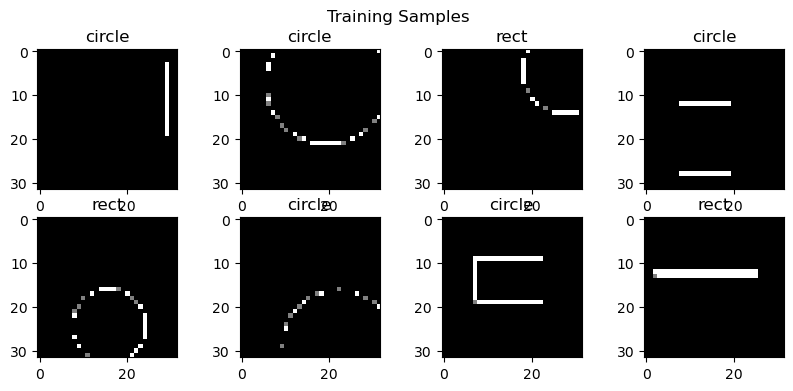

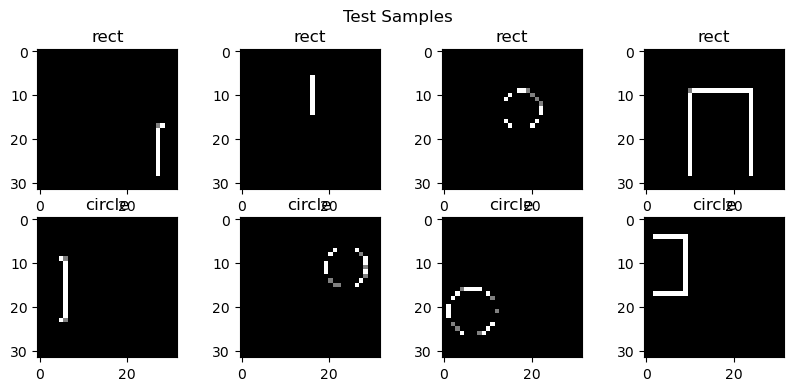

In [11]:
# Show datset samples.
showRandDataset(dataset=trainData, indices=range(0,len(trainData)), classes=trainData.classes, sample_size=8, suptitle="Training Samples")
showRandDataset(dataset=testData, indices=range(0,len(testData)), classes=testData.classes, sample_size=8, suptitle="Test Samples")


## Splitting Dataset

In [12]:
# calculate the train/validation split
(trainData, valData) = random_split(trainData, [int(len(trainData) * TRAIN_SPLIT), len(trainData) - int(len(trainData) * TRAIN_SPLIT)], generator=torch.Generator().manual_seed(RAND_SEED))


In [24]:
showDataDist(trainData.dataset.classes, trainData.dataset.targets[trainData.indices], "Training set")
showDataDist(valData.dataset.classes, valData.dataset.targets[valData.indices], "Validation set")
showDataDist(testData.classes, testData.targets, "Test set")

Training set 1600(1.00) : circle 833(0.52), rect 767(0.48), 
Validation set 400(1.00) : circle 202(0.51), rect 198(0.49), 
Test set 200(1.00) : circle 101(0.51), rect 99(0.49), 


## Data Loader

In [12]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE
print(f"Training steps: {trainSteps}, Validation steps: {valSteps}")

Training steps: 100, Validation steps: 25


## Model Construction

In [13]:
# initialize the LeNet model
model = LeNet(numChannels=1, classes=len(trainData.dataset.classes), imageShape=trainData.dataset[0][0].size()[1:]).to(DEVICE)
inputShape = (1,INPUT_DIM,INPUT_DIM)
summary(model, inputShape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 28, 28]          520
├─ReLU: 1-2                              [-1, 20, 28, 28]          --
├─MaxPool2d: 1-3                         [-1, 20, 14, 14]          --
├─Conv2d: 1-4                            [-1, 50, 10, 10]          25,050
├─ReLU: 1-5                              [-1, 50, 10, 10]          --
├─MaxPool2d: 1-6                         [-1, 50, 5, 5]            --
├─Flatten: 1-7                           [-1, 1250]                --
├─Linear: 1-8                            [-1, 500]                 625,500
├─ReLU: 1-9                              [-1, 500]                 --
├─Linear: 1-10                           [-1, 2]                   1,002
├─LogSoftmax: 1-11                       [-1, 2]                   --
Total params: 652,072
Trainable params: 652,072
Non-trainable params: 0
Total mult-adds (M): 3.52
Input size (MB): 0.00
Forward/backward pass 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 28, 28]          520
├─ReLU: 1-2                              [-1, 20, 28, 28]          --
├─MaxPool2d: 1-3                         [-1, 20, 14, 14]          --
├─Conv2d: 1-4                            [-1, 50, 10, 10]          25,050
├─ReLU: 1-5                              [-1, 50, 10, 10]          --
├─MaxPool2d: 1-6                         [-1, 50, 5, 5]            --
├─Flatten: 1-7                           [-1, 1250]                --
├─Linear: 1-8                            [-1, 500]                 625,500
├─ReLU: 1-9                              [-1, 500]                 --
├─Linear: 1-10                           [-1, 2]                   1,002
├─LogSoftmax: 1-11                       [-1, 2]                   --
Total params: 652,072
Trainable params: 652,072
Non-trainable params: 0
Total mult-adds (M): 3.52
Input size (MB): 0.00
Forward/backward pass 

## Inferencing

C:\Users\User\AppData\Local\Temp\ipykernel_17124\4058749131.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


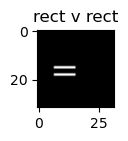

In [14]:
# Load data.
x, y_hat = testData[0]
x = x.to(DEVICE)
label_hat = testData.classes[y_hat]

# Inference.
y = model(x.unsqueeze(0))
y = np.argmax(y.to(torch.device('cpu')).detach().numpy())
label = testData.classes[y]

fig = plt.figure(figsize=(1,1))
axes = fig.subplots(1,1)
axes.imshow(x.permute(1,2,0).to(torch.device('cpu')).detach().numpy(), 'gray')
axes.set_title(f"{label_hat} v {label}")
fig.show()

## Model Training

Choice of loss/cost function should match to the output layer of the network. In this case, we have to determine categorical cross-entropy loss. Since LeNet has LogSoftmax at the output layer then we use nn.NLLoss or negative log-likelihood. If the network has Linear at the output layer then we use nn.CrossEntropyLoss loss.

In PyTorch framework, in any training loop, we must compile the exact order:<br>
`opt.zero_grad()`<br>
`loss.backward()`<br>
`opt.step()`<br>
, before do anything else.

In [16]:
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss() # negative log-likelihood

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step, and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
  
	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainData)
	valCorrect = valCorrect / len(valData)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))


EPOCH: 1/20
Train loss: 0.459544, Train accuracy: 0.7512
Val loss: 0.167521, Val accuracy: 0.9325

EPOCH: 2/20
Train loss: 0.105561, Train accuracy: 0.9613
Val loss: 0.074999, Val accuracy: 0.9675

EPOCH: 3/20
Train loss: 0.049171, Train accuracy: 0.9800
Val loss: 0.054609, Val accuracy: 0.9825

EPOCH: 4/20
Train loss: 0.034636, Train accuracy: 0.9900
Val loss: 0.066322, Val accuracy: 0.9775

EPOCH: 5/20
Train loss: 0.024165, Train accuracy: 0.9906
Val loss: 0.041229, Val accuracy: 0.9850

EPOCH: 6/20
Train loss: 0.015062, Train accuracy: 0.9956
Val loss: 0.027144, Val accuracy: 0.9900

EPOCH: 7/20
Train loss: 0.074051, Train accuracy: 0.9850
Val loss: 0.290542, Val accuracy: 0.8950

EPOCH: 8/20
Train loss: 0.041444, Train accuracy: 0.9869
Val loss: 0.038369, Val accuracy: 0.9850

EPOCH: 9/20
Train loss: 0.013980, Train accuracy: 0.9975
Val loss: 0.034425, Val accuracy: 0.9875

EPOCH: 10/20
Train loss: 0.011711, Train accuracy: 0.9962
Val loss: 0.031113, Val accuracy: 0.9875

EPOCH: 11

C:\Users\User\AppData\Local\Temp\ipykernel_17124\2731160465.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


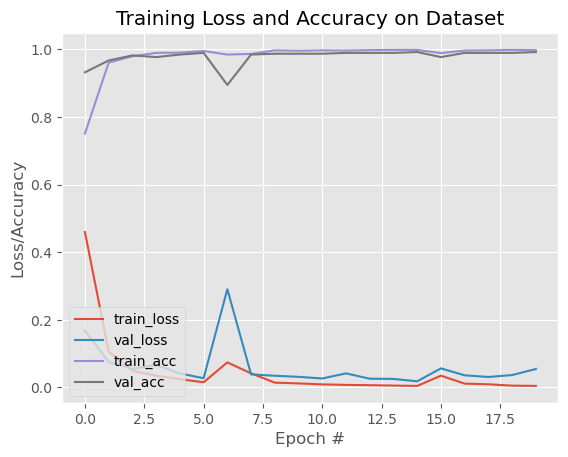

In [17]:
# plot the training loss and accuracy
# matplotlib.use("agg") # choose backend rendering engine.
plt.style.use("ggplot")
fig, axes = plt.subplots(1,1)
axes.plot(H["train_loss"], label="train_loss")
axes.plot(H["val_loss"], label="val_loss")
axes.plot(H["train_acc"], label="train_acc")
axes.plot(H["val_acc"], label="val_acc")
axes.set_title("Training Loss and Accuracy on Dataset")
axes.set_xlabel("Epoch #")
axes.set_ylabel("Loss/Accuracy")
axes.legend(loc="lower left")
fig.show()

# save image file.
history_image_filepath = 'results/Shapes/history.png'
os.makedirs(os.path.dirname(history_image_filepath), exist_ok=True)
fig.savefig(history_image_filepath)

## Saving Model

Usually we use `torch.save` to save only model states or moodel weights.


In [18]:
# save model file.
model_filepath = 'model-store\Shapes\LeNet.pt'
os.makedirs(os.path.dirname(model_filepath), exist_ok=True)
torch.save(model, model_filepath)

To save together with model definition, use Just-In-Time or JIT model by `torch.jit.script` or `torch.jit.trace`, which trace model definition/handler, such as forward methods, into intermediate script that is executed during inferencing or runtime (JIT), then `torch.jit.save` to save the JIT model. See https://pytorch.org/docs/stable/jit.html#frequently-asked-questions.

JIT model remembers its original device when it is traced. As soon as you load the JIT model, it will be loaded into the orginal device.

In [19]:
jit_model_filepath = 'model-store/Shapes/JIT_LeNet.pt'
os.makedirs(os.path.dirname(jit_model_filepath), exist_ok=True)
jit_model = torch.jit.script(model)
torch.jit.save(jit_model, jit_model_filepath)

## Model Evaluation

In [20]:
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(DEVICE)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(), np.array(preds), target_names=testData.classes))

c:\Users\User\.conda\envs\basex\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


              precision    recall  f1-score   support

      circle       1.00      0.98      0.99       101
        rect       0.98      1.00      0.99        99

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



## Loading Model

In [24]:
# load the model and set it to evaluation mode
model_filepath = 'model-store\Shapes\LeNet.pt'
model = torch.load(model_filepath)

# # load the model and set it to evaluation mode
# model_filepath = 'model-store\Shapes\JIT_LeNet.pt'
# model = torch.jit.load(model_filepath)

model.to(DEVICE)

## Model Implementation

C:\Users\User\AppData\Local\Temp\ipykernel_17124\2505965620.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 200 + 1) instead
  idc = np.random.random_integers(0, len(dataset), sample_size)
c:\Users\User\.conda\envs\basex\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_17124\2505965

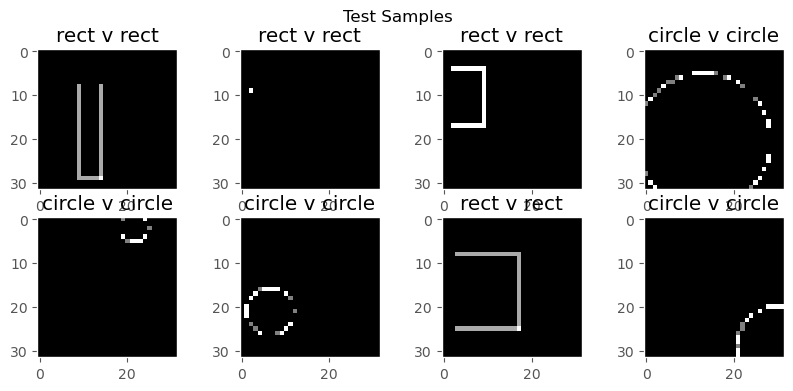

In [125]:
showRandDataset(testData, 8, suptitle="Test Samples", model=model)